 # **HOUSE PRICE PREDICTION FULL ANALYSIS**

<hr>

> ### *Importing Libraries*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

>### *Loading Datset*

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
# Display shape and first few rows of train data
print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<hr>

>### *Exploratory Data Analysis (EDA)*

##### Check Missing Values and Data Types

In [5]:
# Count of missing values in each column (train set)
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

In [6]:
# Show top 15 columns with most missing values
missing_values.head(15)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
dtype: int64

##### Visualize SalePrice Distribution

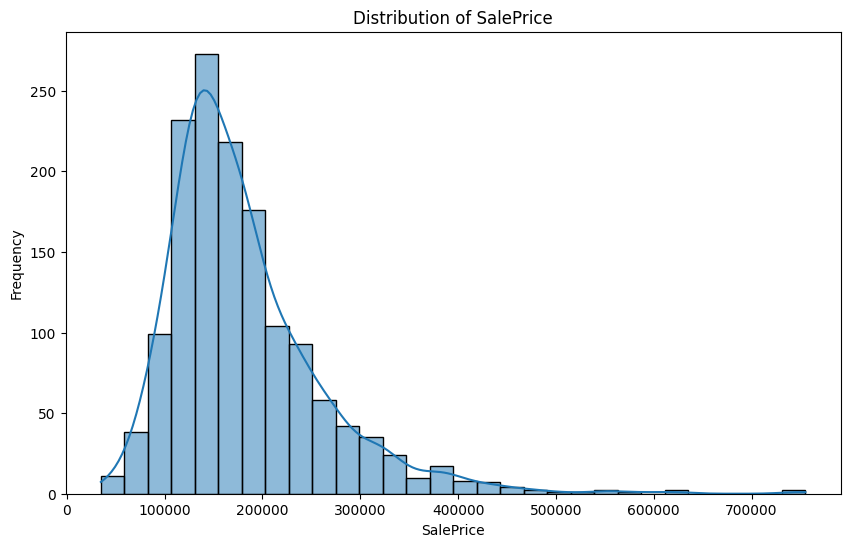

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=30)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

##### Correlation Heatmap (Numerical Features)

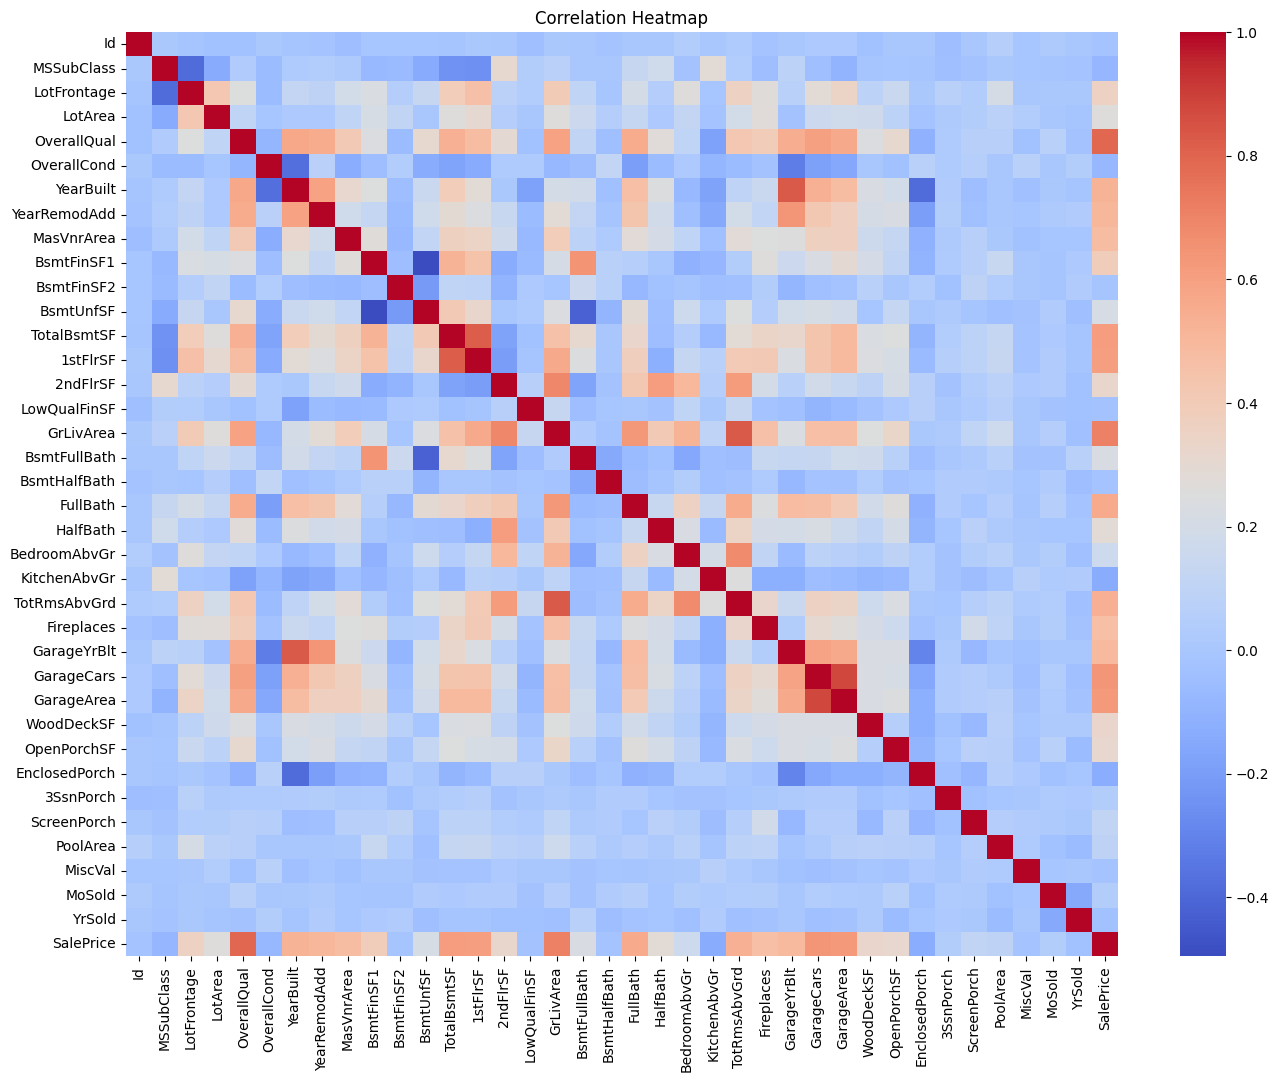

In [8]:
corr = train_df.corr(numeric_only=True)
plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [9]:
top_corr = corr['SalePrice'].abs().sort_values(ascending=False).head(10)
print(top_corr)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


##### Relationship Plots with Top Features

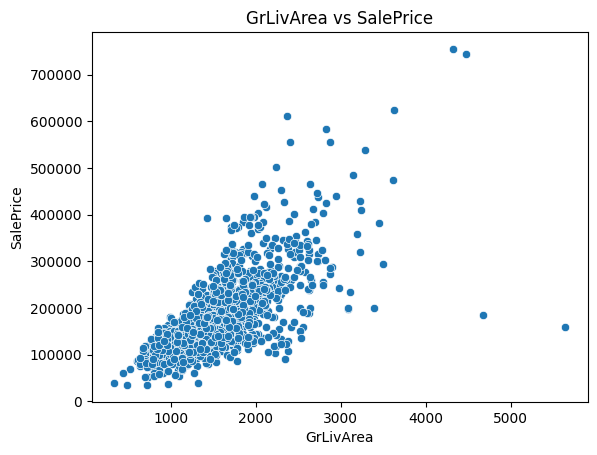

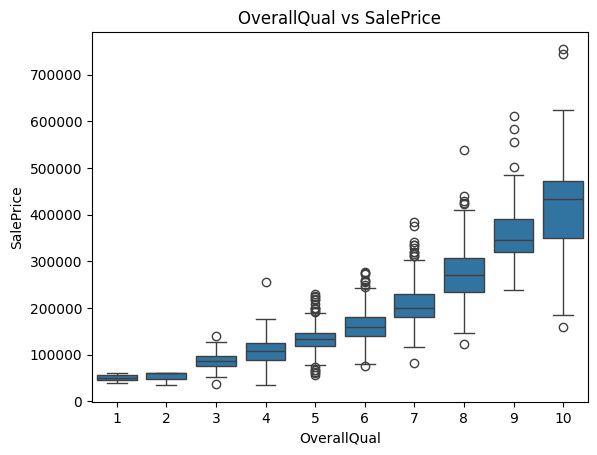

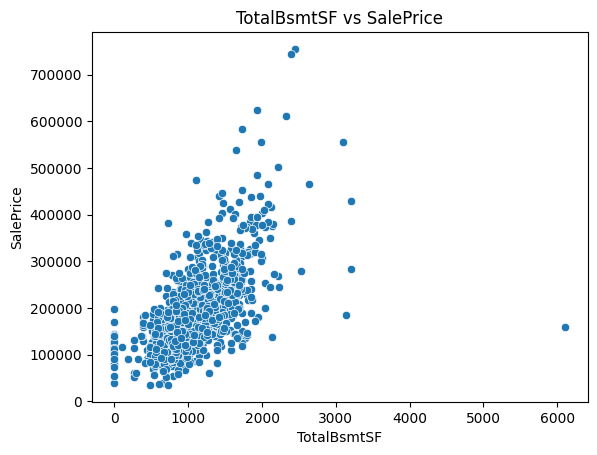

In [10]:
# GrLivArea vs SalePrice
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df)
plt.title("GrLivArea vs SalePrice")
plt.show()

# OverallQual vs SalePrice
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df)
plt.title("OverallQual vs SalePrice")
plt.show()

# TotalBsmtSF vs SalePrice
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train_df)
plt.title("TotalBsmtSF vs SalePrice")
plt.show()

##### Missing Data Heatmap

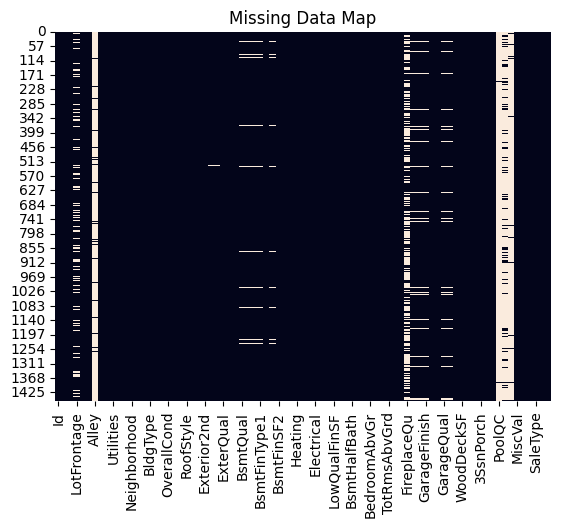

In [11]:
sns.heatmap(train_df.isnull(), cbar=False)
plt.title("Missing Data Map")
plt.show()

<hr>

>### *Data Cleaning & Feature Engineering*

##### Handle Missing Values

In [12]:
# Drop columns with too many missing values
cols_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
train_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)

In [13]:
# Impute Categorical Features with 'None'
cat_none_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                 'MasVnrType']

for col in cat_none_cols:
    train_df[col].fillna('None', inplace=True)
    test_df[col].fillna('None', inplace=True)

In [14]:
# Impute Numerical Features with 0 or Median
num_zero_cols = ['GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']

for col in num_zero_cols:
    train_df[col].fillna(0, inplace=True)
    test_df[col].fillna(0, inplace=True)

# LotFrontage by Neighborhood median
train_df['LotFrontage'] = train_df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
test_df['LotFrontage'] = test_df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [15]:
# Impute 'Electrical' and other rare cases with mode
train_df['Electrical'].fillna(train_df['Electrical'].mode()[0], inplace=True)
test_df['Electrical'].fillna(test_df['Electrical'].mode()[0], inplace=True)

##### Encode Categorical Features

In [16]:
all_data = pd.concat([train_df.drop('SalePrice', axis=1), test_df], axis=0)

# Label Encode all categorical columns
for col in all_data.select_dtypes(include='object').columns:
    le = LabelEncoder()
    all_data[col] = le.fit_transform(all_data[col].astype(str))

# Split again
X_train = all_data[:len(train_df)]
X_test = all_data[len(train_df):]
y_train = train_df['SalePrice']

<hr>

>### Define Evaluation Metrics for Regression Models

In [ ]:
evaluation_results = []

# Evaluation function
def evaluate_model(model_name,y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    evaluation_results.append({
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

    print(f"MAE  : {mae:.2f}")
    print(f"MSE  : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.4f}")
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}


<hr>

>### *Preparing Train/Test Data for Model Training*

In [18]:
# Create validation split
X_train_final, X_valid, y_train_final, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("Training data shape :", X_train_final.shape)
print("Validation data shape:", X_valid.shape)
print("Test data shape      :", X_test.shape)

Training data shape : (1168, 75)
Validation data shape: (292, 75)
Test data shape      : (1459, 75)


<hr>

>### *Model Training*

##### 1. Linear Regression

Evaluation Metrics: 
MAE  : 21482.95
MSE  : 1166645859.76
RMSE : 34156.20
R²   : 0.8479


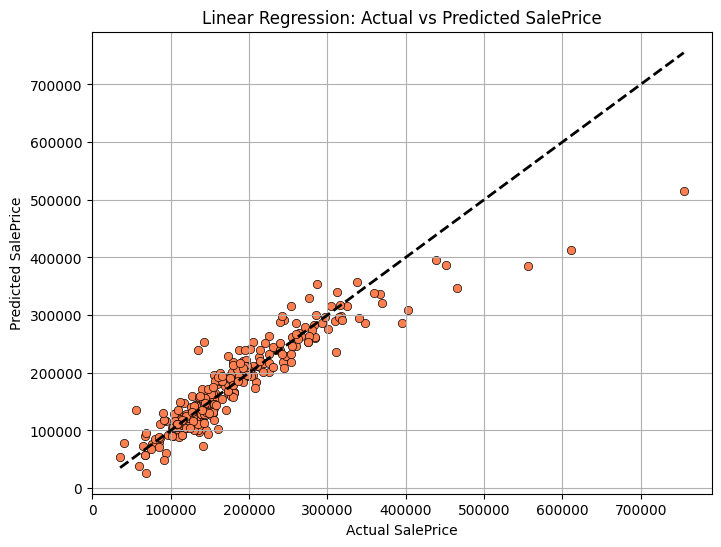

In [19]:
# Train model
lr_model = LinearRegression()
lr_model.fit(X_train_final, y_train_final)

# Predict
y_pred_lr = lr_model.predict(X_valid)

# Evaluation Metrics
print("Evaluation Metrics: ")
evaluate_model("Linear Regression",y_valid, y_pred_lr)

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_valid, y=y_pred_lr, color='coral', edgecolor='k')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Linear Regression: Actual vs Predicted SalePrice')
plt.grid(True)
plt.show()

##### 2. Multiple Linear Regression

Evaluation Metrics: 
MAE  : 21482.95
MSE  : 1166645859.76
RMSE : 34156.20
R²   : 0.8479


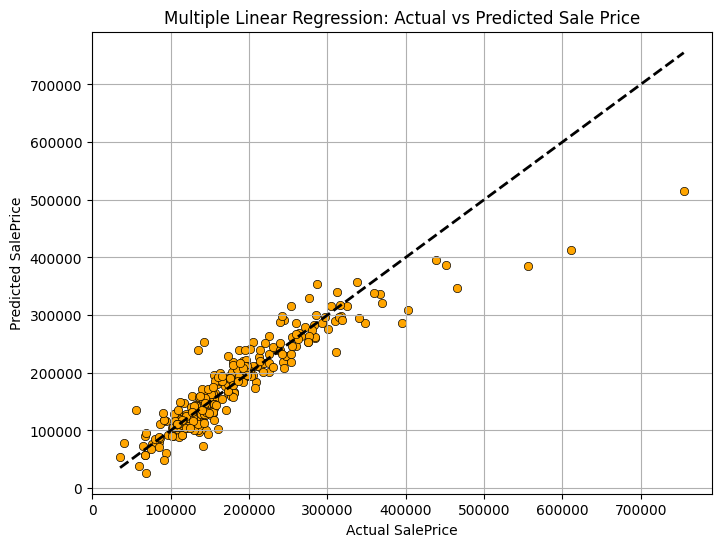

In [20]:
mlr_model = LinearRegression()
mlr_model.fit(X_train_final, y_train_final)

y_pred_mlr = mlr_model.predict(X_valid)

print("Evaluation Metrics: ")
evaluate_model("Multiple Linear Regression",y_valid, y_pred_mlr)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_valid, y=y_pred_mlr, color='orange', edgecolor='k')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Multiple Linear Regression: Actual vs Predicted Sale Price")
plt.grid(True)
plt.show()

##### 3. Ridge Regression

Evaluation Metrics: 
MAE  : 21464.84
MSE  : 1168060300.77
RMSE : 34176.90
R²   : 0.8477


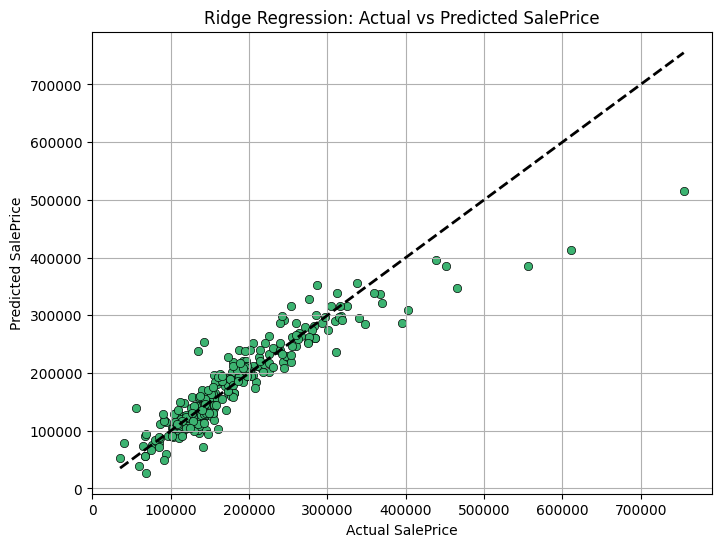

In [21]:
# Model with alpha (regularization strength)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_final, y_train_final)

# Predict
y_pred_ridge = ridge_model.predict(X_valid)

print("Evaluation Metrics: ")
evaluate_model("Ridge Regression",y_valid, y_pred_ridge)

# Plot: Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_valid, y=y_pred_ridge, color='mediumseagreen', edgecolor='k')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Ridge Regression: Actual vs Predicted SalePrice')
plt.grid(True)
plt.show()

##### 4. Lasso Regression

Evaluation Metrics: 
MAE  : 21482.95
MSE  : 1166645892.40
RMSE : 34156.20
R²   : 0.8479


c:\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.330e+10, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


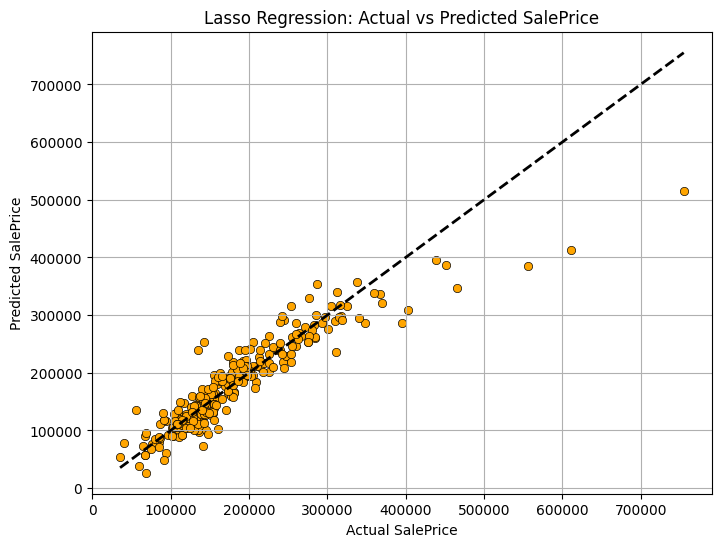

In [22]:
# Lasso model
lasso_model = Lasso(alpha=0.001, max_iter=10000)  
lasso_model.fit(X_train_final, y_train_final)

# Predict
y_pred_lasso = lasso_model.predict(X_valid)

print("Evaluation Metrics: ")
evaluate_model("Lasso Regression",y_valid, y_pred_lasso)

# Plot: Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_valid, y=y_pred_lasso, color='orange', edgecolor='k')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Lasso Regression: Actual vs Predicted SalePrice')
plt.grid(True)
plt.show()

##### 5. ElasticNet Regression

Evaluation Metrics: 
MAE  : 21465.78
MSE  : 1167605524.18
RMSE : 34170.24
R²   : 0.8478


c:\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.177e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


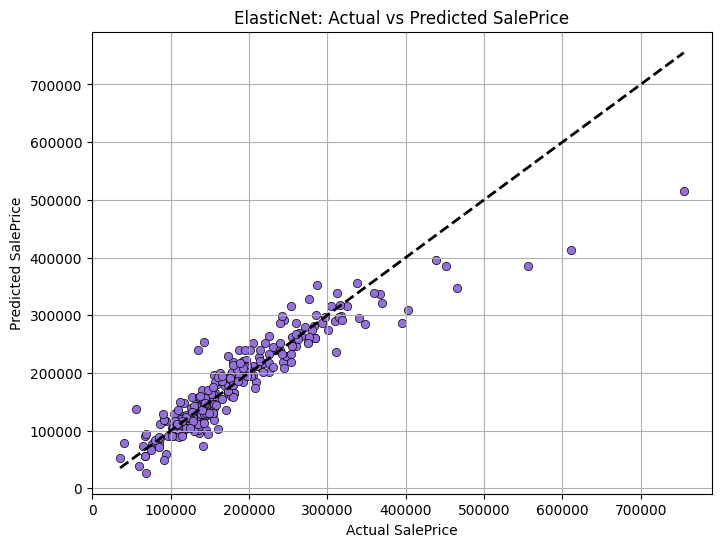

In [23]:
# ElasticNet model
elastic_model = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000)
elastic_model.fit(X_train_final, y_train_final)

# Predict
y_pred_elastic = elastic_model.predict(X_valid)

print("Evaluation Metrics: ")
evaluate_model("ElasticNet Regression",y_valid, y_pred_elastic)

# Plot: Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_valid, y=y_pred_elastic, color='mediumpurple', edgecolor='k')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('ElasticNet: Actual vs Predicted SalePrice')
plt.grid(True)
plt.show()

##### 6. Polynomial Regression

Evaluation Metrics: 
MAE  : 205557.04
MSE  : 303019579188.83
RMSE : 550472.14
R²   : -38.5054


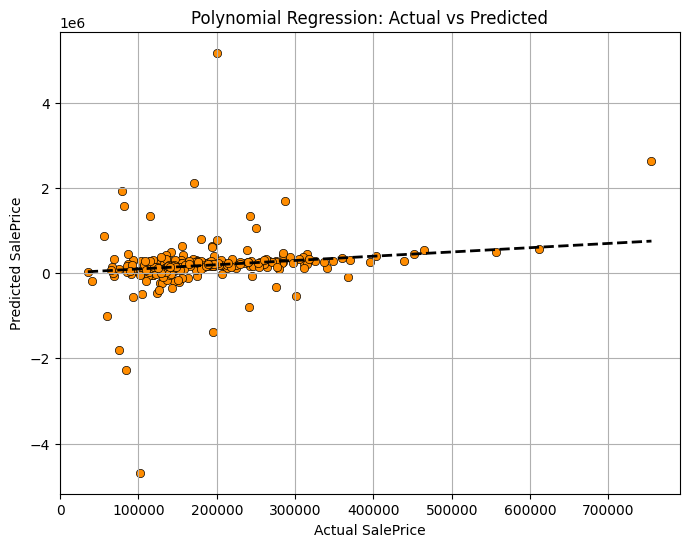

In [24]:
# Creating polynomial features (degree=2 for now)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_final)
X_valid_poly = poly.transform(X_valid)

# Fitting Linear Regression on transformed data
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_final)

# Predicting and calculate RMSE
y_pred_poly = poly_model.predict(X_valid_poly)
print("Evaluation Metrics: ")
evaluate_model("Polynomial Regression",y_valid, y_pred_poly)

# Plotting actual vs predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_valid, y=y_pred_poly, color='darkorange', edgecolor='k')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Polynomial Regression: Actual vs Predicted")
plt.grid(True)
plt.show()


##### 7. k-Nearest Neighbors (kNN) Regression

Evaluation Metrics: 
MAE  : 29717.80
MSE  : 2395375987.31
RMSE : 48942.58
R²   : 0.6877


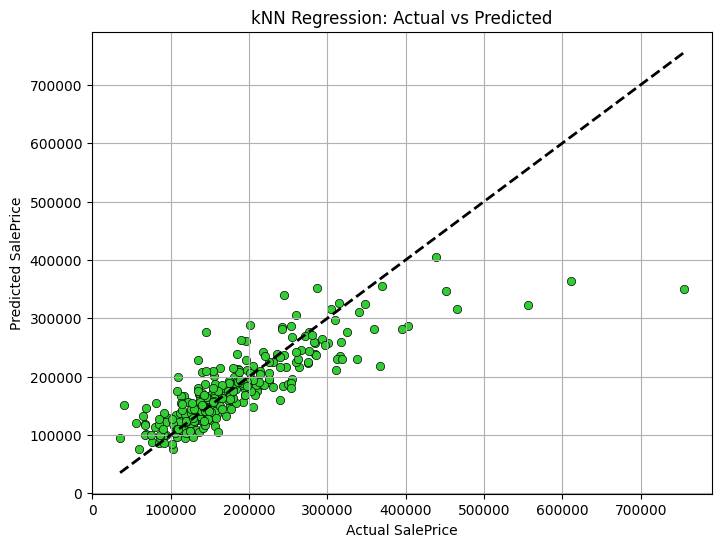

In [25]:
knn_model = KNeighborsRegressor(n_neighbors=5)  
knn_model.fit(X_train_final, y_train_final)

y_pred_knn = knn_model.predict(X_valid)

print("Evaluation Metrics: ")
evaluate_model("KNN Regression",y_valid, y_pred_knn)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_valid, y=y_pred_knn, color='limegreen', edgecolor='k')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("kNN Regression: Actual vs Predicted")
plt.grid(True)
plt.show()

##### 8. Support Vector Regression (SVR)

Evaluation Metrics: 
MAE  : 59473.04
MSE  : 7853463332.28
RMSE : 88619.77
R²   : -0.0239


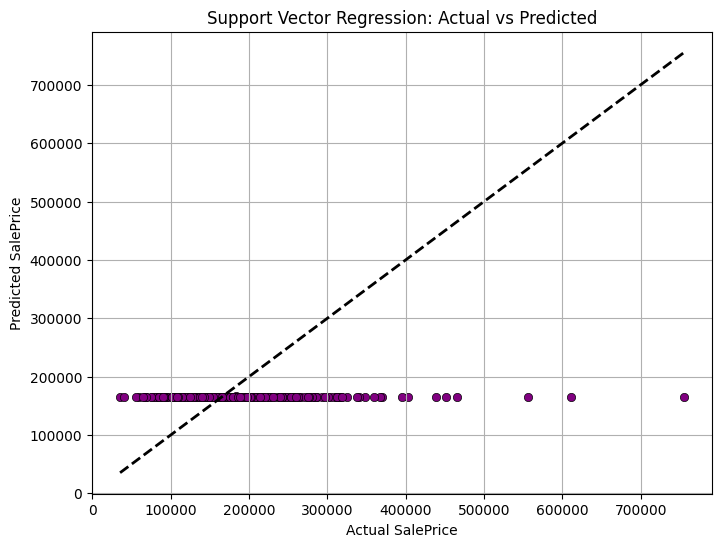

In [26]:
scaler = StandardScaler()
X_train_svr = scaler.fit_transform(X_train_final)
X_valid_svr = scaler.transform(X_valid)

svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train_svr, y_train_final)

y_pred_svr = svr_model.predict(X_valid_svr)
print("Evaluation Metrics: ")
evaluate_model("SVR Regression",y_valid, y_pred_svr)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_valid, y=y_pred_svr, color='purple', edgecolor='k')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Support Vector Regression: Actual vs Predicted")
plt.grid(True)
plt.show()

##### 9. Decision Tree Regression

Evaluation Metrics: 
MAE  : 27522.87
MSE  : 1551192887.39
RMSE : 39385.19
R²   : 0.7978


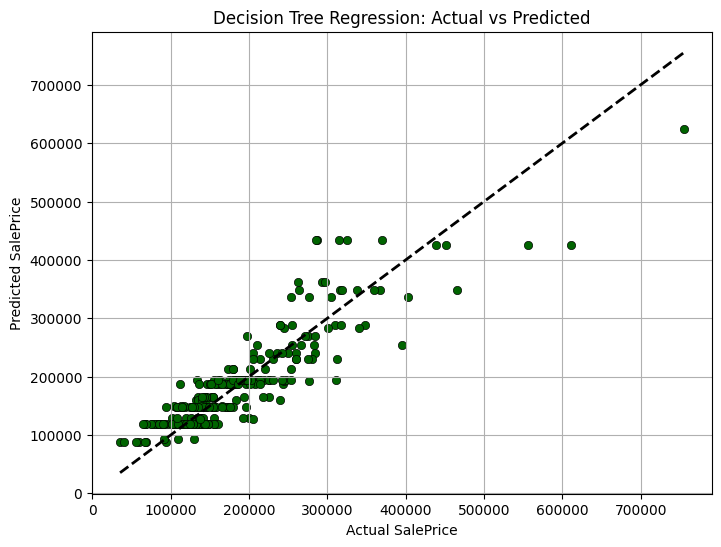

In [27]:
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train_final, y_train_final)

y_pred_dt = dt_model.predict(X_valid)

print("Evaluation Metrics: ")
evaluate_model("Decision Tree Regression",y_valid, y_pred_dt)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_valid, y=y_pred_dt, color='darkgreen', edgecolor='k')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Decision Tree Regression: Actual vs Predicted")
plt.grid(True)
plt.show()

##### 10. Random Forest Regression

Evaluation Metrics: 
MAE  : 17811.97
MSE  : 830497166.36
RMSE : 28818.35
R²   : 0.8917


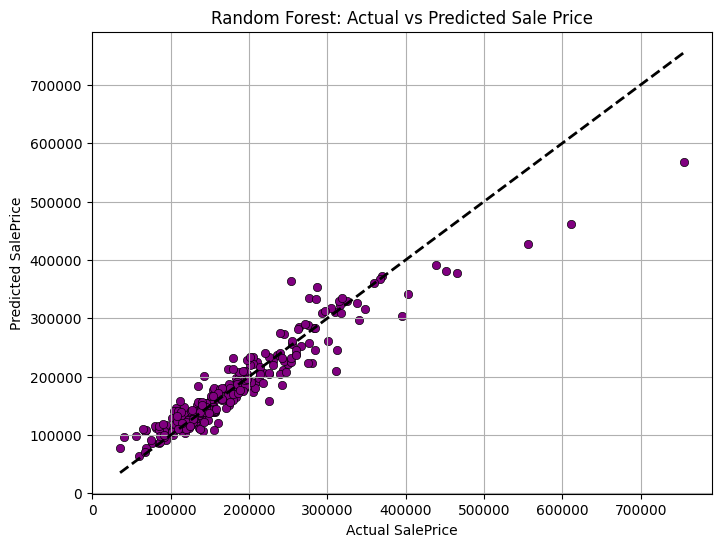

In [28]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_final, y_train_final)

y_pred_rf = rf_model.predict(X_valid)

print("Evaluation Metrics: ")
evaluate_model("Random Forest Regression",y_valid, y_pred_rf)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_valid, y=y_pred_rf, color='purple', edgecolor='k')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Random Forest: Actual vs Predicted Sale Price")
plt.grid(True)
plt.show()

<hr>

>### Evaluation Metrics Comparison of All Models

In [29]:
results_df = pd.DataFrame(evaluation_results)
results_df = results_df.sort_values(by="RMSE")
print(results_df)

                        Model            MAE           MSE           RMSE  \
9    Random Forest Regression   17811.968031  8.304972e+08   28818.347738   
0           Linear Regression   21482.954694  1.166646e+09   34156.197970   
1  Multiple Linear Regression   21482.954694  1.166646e+09   34156.197970   
3            Lasso Regression   21482.952065  1.166646e+09   34156.198448   
4       ElasticNet Regression   21465.781925  1.167606e+09   34170.243256   
2            Ridge Regression   21464.835662  1.168060e+09   34176.897179   
8    Decision Tree Regression   27522.865011  1.551193e+09   39385.186141   
6              KNN Regression   29717.799315  2.395376e+09   48942.578470   
7              SVR Regression   59473.041958  7.853463e+09   88619.768293   
5       Polynomial Regression  205557.042869  3.030196e+11  550472.142064   

          R2  
9   0.891726  
0   0.847901  
1   0.847901  
3   0.847901  
4   0.847776  
2   0.847717  
8   0.797767  
6   0.687709  
7  -0.023876  
5 

C:\Users\Rajesh\AppData\Local\Temp\ipykernel_7008\1233994538.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=results_df, palette='coolwarm_r')


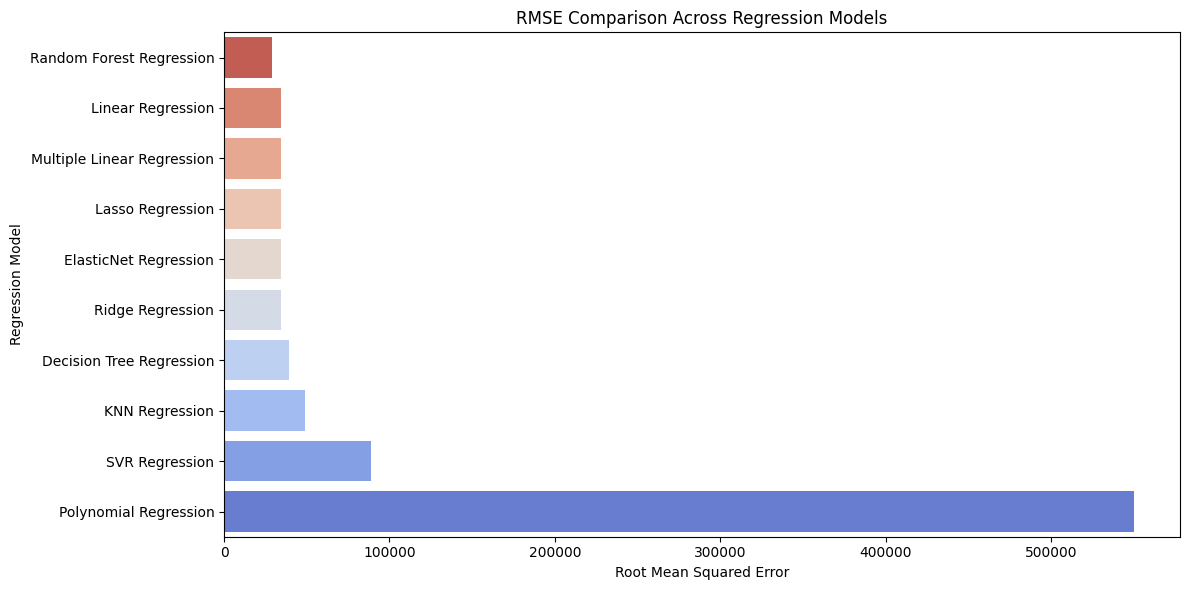

In [30]:
plt.figure(figsize=(12, 6))
sns.barplot(x='RMSE', y='Model', data=results_df, palette='coolwarm_r')
plt.title("RMSE Comparison Across Regression Models")
plt.xlabel("Root Mean Squared Error")
plt.ylabel("Regression Model")
plt.tight_layout()
plt.show()

C:\Users\Rajesh\AppData\Local\Temp\ipykernel_7008\1210373079.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2', y='Model', data=results_df, palette='crest')


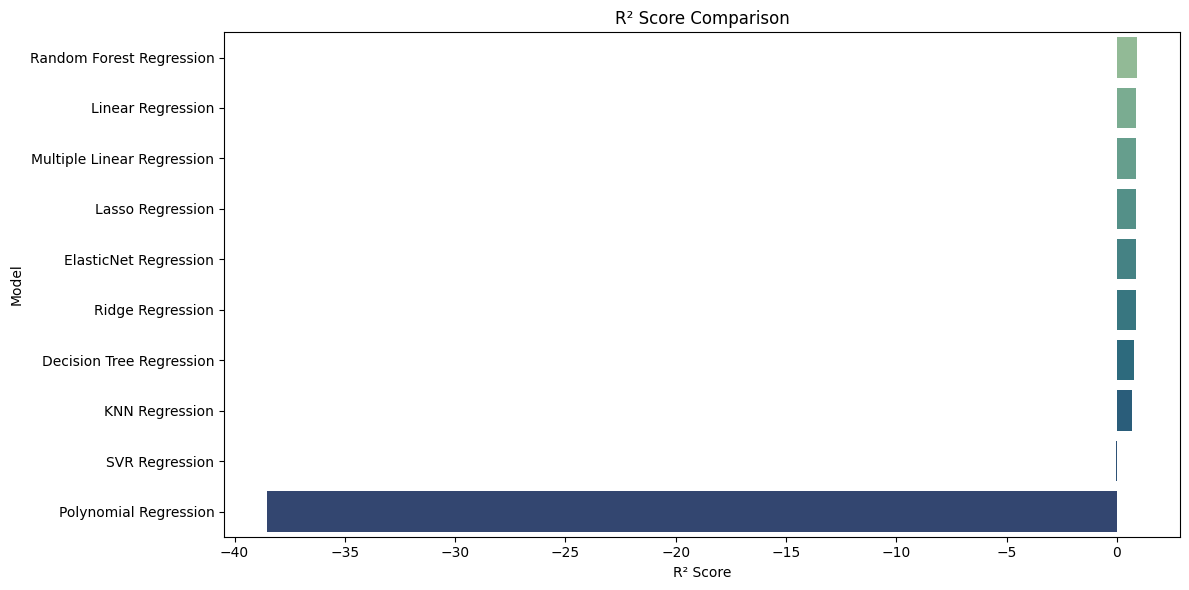

In [31]:
# R2 score comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='R2', y='Model', data=results_df, palette='crest')
plt.title("R² Score Comparison")
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

Best Model: Random Forest
- RMSE: 28818.34 → lowest among all models [More less more better model]
- R2: 0.891726 → highest among all models [CLosest to 1 - more better model]

<hr>

>### Prediction on TEST set

In [32]:
rf_test_preds = rf_model.predict(X_test)

submission_df = pd.DataFrame({
    'Id': test_df['Id'],       # Use original test Ids
    'SalePrice': rf_test_preds # Predicted prices
})

submission_df.to_csv('random_forest_submission.csv', index=False)

submission_df.head()

,Id,SalePrice
0,1461,128156.661435
1,1462,155107.809357
2,1463,176741.536218
3,1464,186504.295566
4,1465,208680.825109


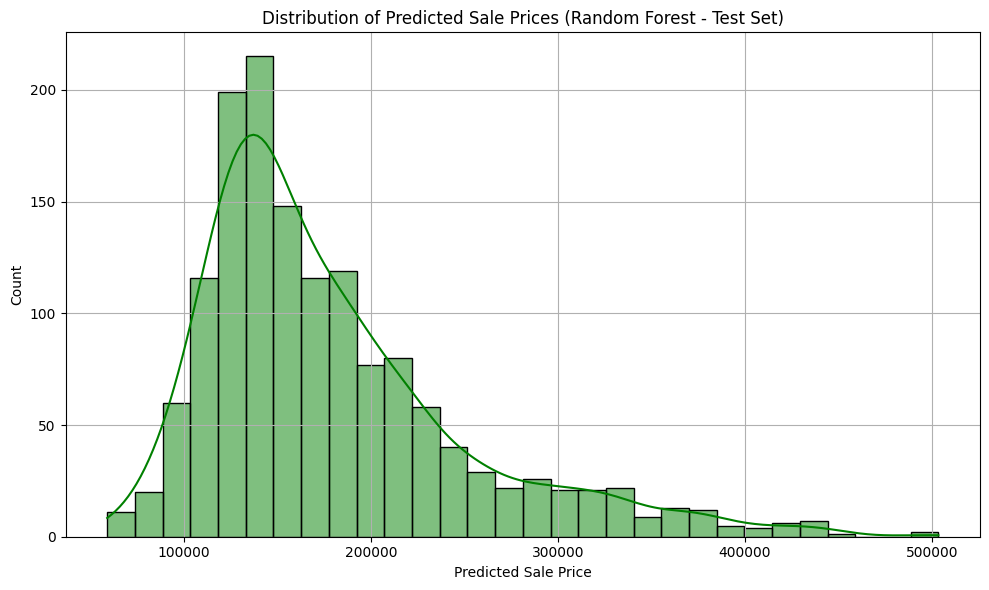

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(rf_test_preds, bins=30, kde=True, color='green')
plt.title("Distribution of Predicted Sale Prices (Random Forest - Test Set)")
plt.xlabel("Predicted Sale Price")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

<hr>